# Load Dataset

In [1]:
!pip install gdown
import os
import gdown
import zipfile

if not os.path.isdir("Mushrooms"):
  url = 'https://drive.google.com/uc?id=1BUD8rvVAwon48pnMmUJAKIoZE8AqTRhy'
  output = 'Mushrooms.zip'
  gdown.download(url, output, quiet=False)
  with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From: https://drive.google.com/uc?id=1BUD8rvVAwon48pnMmUJAKIoZE8AqTRhy
To: /content/Mushrooms.zip
995MB [00:05, 192MB/s]


In [2]:
!pip install jupyter_contrib_nbextensions
!pip install fastai
!pip install fastai --upgrade
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 20.9MB 1.4MB/s 
     |████████████████████████████████| 870kB 42.9MB/s 
     |████████████████████████████████| 481kB 20.6MB/s 
  Created wheel for jupyter-latex-envs: filename=jupyter_latex_envs-1.4.6-py2.py3-none-any.whl size=963395 sha256=fe856c59f507596944dea859fe1d4fa933a15946b7fcf1872bd4d79d1c2a664f
  Stored in directory: /root/.cache/pip/wheels/0d/71/2a/164491997299b9f2479a251e254323fe35d946779e18f27956
  Created wheel for jupyter-nbextensions-configurator: filename=jupyter_nbextensions_configurator-0.4.1-py2.py3-none-any.whl size=465825 sha256=c1fca021ff44ba73e55211968dffda2bec760af0183a20ef6e037e2ac256feaa
  Stored in directory: /root/.cache/pip/wheels/15/df/fe/2a74fe34709e7fdc5ae153a768675d9fda93cc7d5133ed1fb0
Successfully built jupyter-latex-envs jupyter-nbextensions-configurator
     |████████████████████████████████| 358kB 6.6MB/s 
     |████████████████████████████████| 40kB 5.3MB/s 
  Found existing installation: fastai 1.0.61
    

In [3]:
import numpy as np 
import pandas as pd 
import os


from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders
from fastai.metrics import error_rate

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)

In [107]:
batch_size=64
classes = ['Boletus','Entoloma','Russula','Suillus','Lactarius','Amanita','Agaricus','Hygrocybe','Cortinarius']

In [108]:
path = Path("Mushrooms")
print(path)

Mushrooms


In [109]:
# Read dataset and split on train and validation sets. Validation = 20% of dataset.
dls_tmp = ImageDataLoaders.from_folder(path,
                                   valid_pct=0.4,
                                   item_tfms=Resize(224),
                                   batch_tfms=Normalize.from_stats(*imagenet_stats),
                                   num_workers=4,
                                   bs=batch_size,
                                   val_bs=batch_size,
                                  )

In [110]:
import random

def label_func(x): return x.parent.name
def dataloader_from_items(items, valid_pct):
  return ImageDataLoaders.from_path_func(
    path, 
    items, 
    label_func,
    item_tfms=Resize(224),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    num_workers=4,
    valid_pct=valid_pct,
    bs=batch_size)

valid_items = dls_tmp.valid.items
random.shuffle(valid_items)
# Split validation set on two equal parts: test and validation.
# Resulting sizes (approximately) train: 64%, validation: 16%, test: 20% of the dataset.
# Note: test should have batches of equal sizes (64 by default), otherwise predictions will crush.
test_dls = dataloader_from_items(valid_items[:len(valid_items)//batch_size//2*batch_size], valid_pct=0.0)
dls = dataloader_from_items(valid_items[len(valid_items)//batch_size//2*batch_size:]+dls_tmp.train.items, valid_pct=0.2)
print("Train size: {}, Validation size: {}, Test size: {}".format(
    len(dls.train.items), len(dls.valid.items), len(test_dls.items)))

2685
Train size: 4348, Validation size: 1086, Test size: 1280


Train/Validation


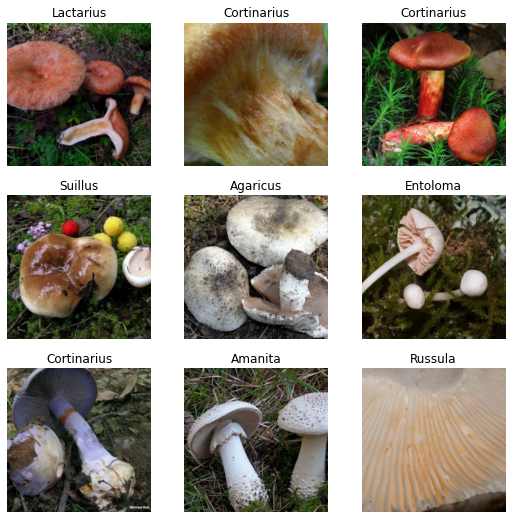

In [111]:
print("Train/Validation")
dls.show_batch()

Test


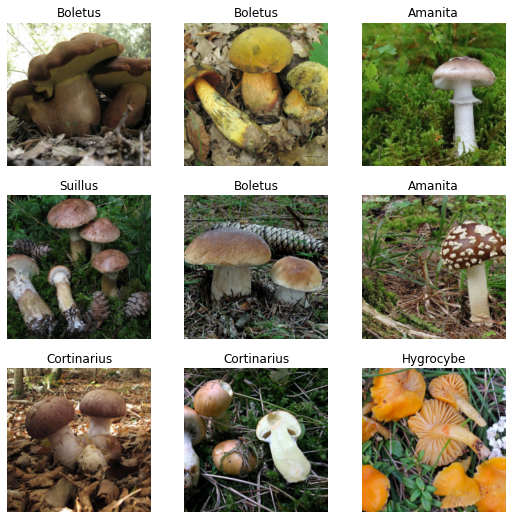

In [112]:
print("Test")
test_dls.show_batch()

# Helper functions

In [79]:
def show_in_row(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

def tensor_to_numpy_image(img):
  # this converts it from GPU to CPU and selects first image
  img = img.cpu().numpy()
  #convert image back to Height,Width,Channels
  img = np.transpose(img, (1,2,0))
  img = img.astype(np.uint8)
  #show the image
  return img

# ResNet50

In [81]:
epochs = 1

epoch,train_loss,valid_loss,error_rate,time
0,1.687582,1.052551,0.295158,01:23


epoch,train_loss,valid_loss,error_rate,time
0,0.783249,0.555156,0.171322,01:47


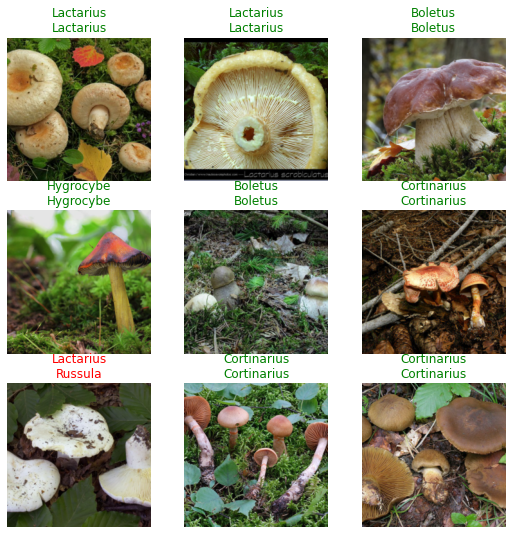

In [82]:
rn50_learn = cnn_learner(dls, resnet50, metrics=error_rate)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
rn50_learn.fine_tune(epochs, 3e-3)
rn50_learn.show_results()

AttributeError: ignored

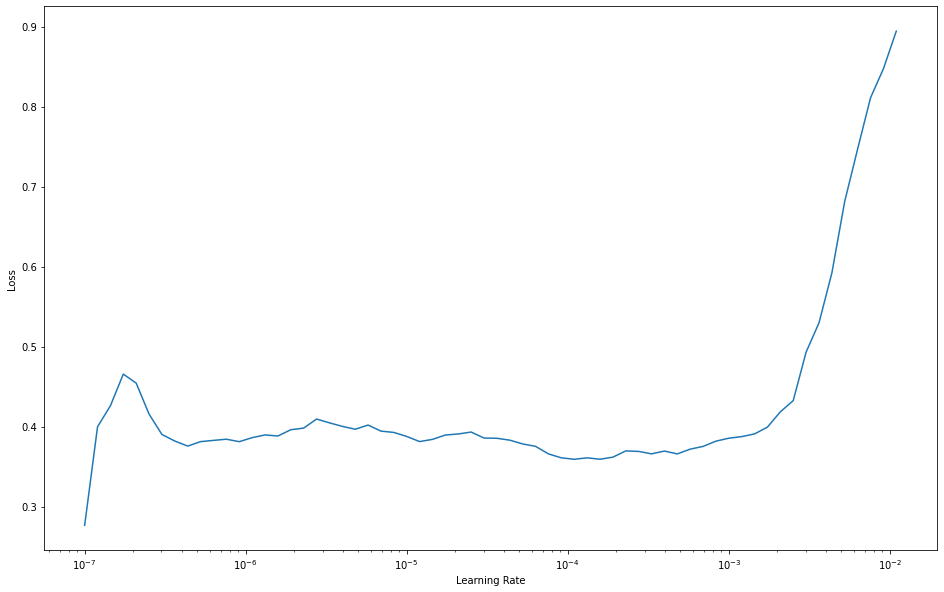

In [83]:
rn50_learn.lr_find()

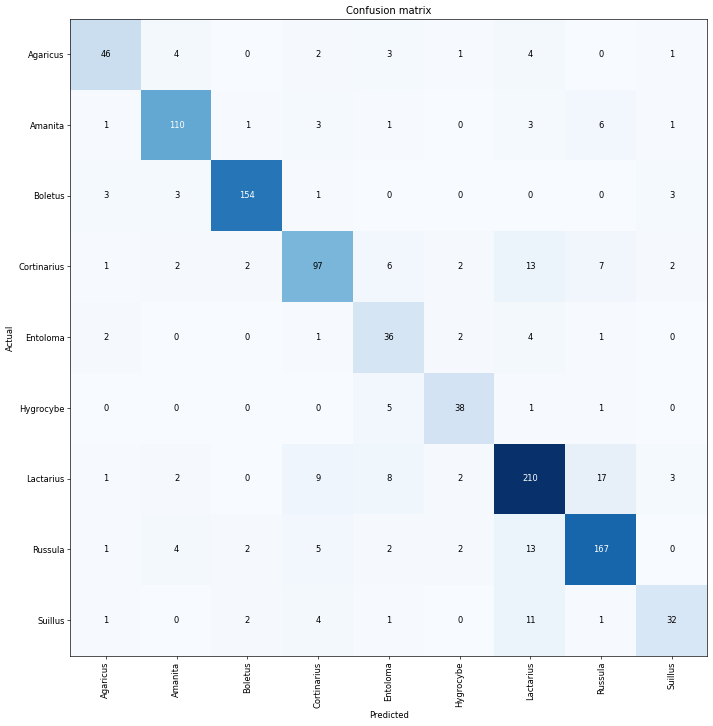

In [84]:
interp = ClassificationInterpretation.from_learner(rn50_learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Comparison

In [119]:
print("ResNet50 accuracy on test set: ", accuracy(*rn50_learn.get_preds(dl=test_dls)).item())

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0af44b9518>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0af44b9518>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel

Accuracy on test set:  0.878125011920929


# Bag of Visual Words (SIFT + SVM)

In [ ]:
# from IPython.display import clear_output
# import numpy as np
# import time
# import cv2
# import math
# import torchvision

In [ ]:
# def processSIFT(img):
#   sift = cv2.xfeatures2d.SIFT_create()
#   return sift.detectAndCompute(img, None)

In [ ]:
# def euclid_dist(v1, v2):
#   diff = v1 - v2
#   return np.sum(diff ** 2) ** 0.5

# def cosine_dist(v1, v2):
#   return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
# from tqdm import tqdm

# def find_closest_idx(descriptors, desc, metric):
#   closest = -1
#   min_dist = -1
#   for i in range(len(descriptors)):
#     dist = metric(descriptors[i], desc)
#     # print(dist)
#     if min_dist == -1 or dist < min_dist:
#       min_dist = dist
#       closest = i
#   return closest

# def kmeans(descriptors, clusters_count, metric, iterations = 50, ):
#   # returns list of clustered point indexes
#   # return list(list(int))
  
#   # step 1
#   if descriptors is None or len(descriptors) == 0:
#     return np.zeros((clusters_count, 128))
#   clusters = descriptors[:clusters_count].copy()
  
#   for iter_idx in range(iterations): 
#     clusters_indexes = [[] for _ in range(clusters_count)] 
#     # step 2
#     for i in range(len(descriptors)):
#       clusters_indexes[find_closest_idx(clusters, descriptors[i], metric)].append(i)
    
#     #step 3
#     for i in range(len(clusters)):
#       clusters[i] = np.mean(descriptors[clusters_indexes[i]], axis=0)
  
#   if len(clusters) < clusters_count:
#     clusters = np.vstack([clusters, np.zeros((clusters_count - len(clusters), 128))])

#   return clusters

In [ ]:
# from sklearn.linear_model import SGDClassifier
# from tqdm import tqdm
# import pickle

# classifier_name = "bag_of_words_svm_dumped.pkl"

# # Try to load pretrained SVM classifier
# if os.path.exists(classifier_name):
#   # load it again
#   with open(classifier_name, 'rb') as fid:
#     svm = pickle.load(fid)
# # else:
#   # Create a SVM, train it on the training data
#   svm = SGDClassifier(warm_start = False, n_jobs=8)
#   features = []
#   labels = []

#   idx = 0
#   for batch in dls.train:
#     print("batch {}/{}".format(idx, len(dls.train)))
#     idx += 1

#     for i in range(len(batch[0])):
#       img = batch[0][i]
#       label = batch[1][i]
#       img = tensor_to_numpy_image(img)
#       kp, descriptors = processSIFT(img)
#       features.append(np.ndarray.flatten(kmeans(descriptors, 20, euclid_dist, 5)))
#       labels.append(label)

#   svm.fit(features, labels)
  
#   # save the classifier
#   with open(classifier_name, 'wb') as fid:
#     pickle.dump(svm, fid)  

batch 0/83
batch 1/83
batch 2/83
batch 3/83
batch 4/83
batch 5/83
batch 6/83
batch 7/83
batch 8/83
batch 9/83
batch 10/83
batch 11/83
batch 12/83
batch 13/83
batch 14/83
batch 15/83
batch 16/83
batch 17/83
batch 18/83
batch 19/83
batch 20/83
batch 21/83
batch 22/83
batch 23/83
batch 24/83
batch 25/83
batch 26/83
batch 27/83


OSError: ignored

In [ ]:
# # In this case 
# for batch in dls.valid:
#     print("batch {}/{}".format(idx, len(dls.train)))
#     idx += 1

#     for i in range(len(batch[0])):
#       img = batch[0][i]
#       label = batch[1][i]
#       img = tensor_to_numpy_image(img)
#       kp, descriptors = processSIFT(img)
#       features.append(np.ndarray.flatten(kmeans(descriptors, 20, euclid_dist, 5)))
#       labels.append(label)